<a href="https://colab.research.google.com/github/jabhij/MusicTherapyTreatment_EmotionDetection/blob/main/Mood_Detection_ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from keras import models
from keras.utils import to_categorical, np_utils

from tensorflow import convert_to_tensor

from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, ZeroPadding2D, Dropout
from tensorflow.keras import models
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/Mood-Detection-Project/challenges-in-representation-learning-facial-expression-recognition-challenge/'

In [4]:
data = pd.read_csv(path + 'icml_face_data.csv')

In [5]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [6]:
# filter rows with emotion == 1
emotion_1 = data[data['emotion'] == 1]

# repeat rows 5 times
repeated_rows = pd.concat([emotion_1] * 6, ignore_index=True)

#concating augmented data and making a new dataframe 
data2 = pd.concat([data, repeated_rows], ignore_index=True)


In [7]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39169 entries, 0 to 39168
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  39169 non-null  int64 
 1    Usage   39169 non-null  object
 2    pixels  39169 non-null  object
dtypes: int64(1), object(2)
memory usage: 918.1+ KB


In [8]:
data2[data2['emotion'] == 1].count()

emotion    3829
 Usage     3829
 pixels    3829
dtype: int64

In [9]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39169 entries, 0 to 39168
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  39169 non-null  int64 
 1    Usage   39169 non-null  object
 2    pixels  39169 non-null  object
dtypes: int64(1), object(2)
memory usage: 918.1+ KB


In [10]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label


def plot_examples(label=0):
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = data[data['emotion']==label].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = data[data['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()
    
def plot_compare_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = emotions.values()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

In [11]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [12]:
train_image_array, train_image_label = prepare_data(data2[data2[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data2[data2[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data2[data2[' Usage']=='PublicTest'])

In [13]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48,48,1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [14]:
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

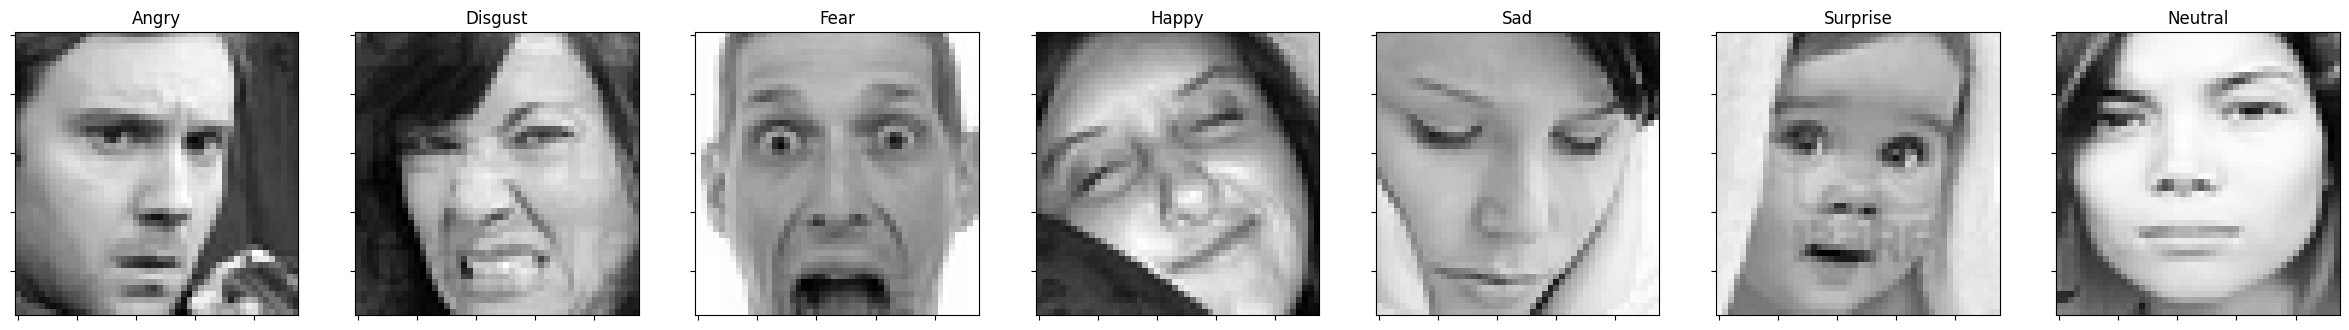

In [15]:
plot_all_emotions()

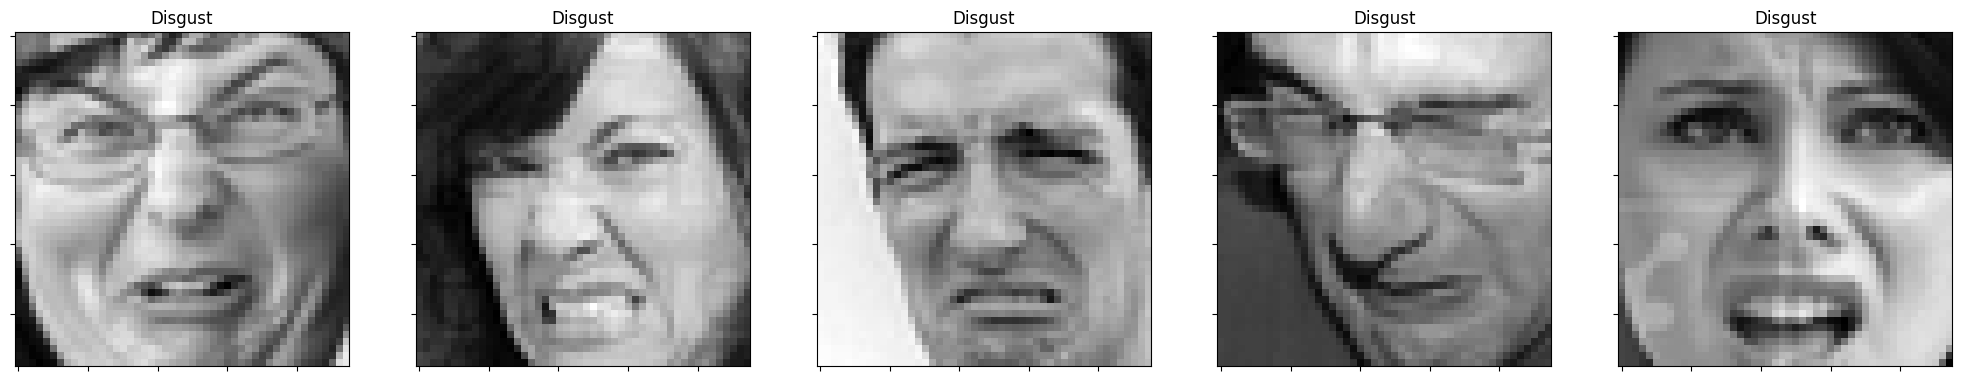

In [16]:
plot_examples(label=1)

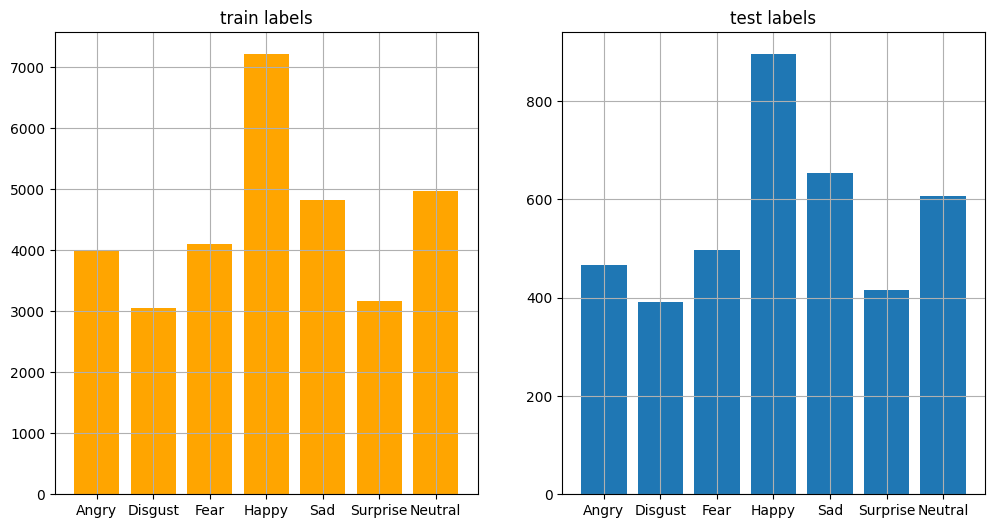

In [17]:
plot_compare_distributions(train_labels, test_labels, title1='train labels', title2='test labels')

In [18]:
class_weight = dict(zip(range(0, 7), (((data2[data2[' Usage']=='Training']['emotion'].value_counts()).sort_index())/len(data2[data2[' Usage']=='Training']['emotion'])).tolist()))

In [19]:
class_weight

{0: 0.1275339185953711,
 1: 0.09743016759776536,
 2: 0.13079010375099762,
 3: 0.2303272146847566,
 4: 0.15418994413407822,
 5: 0.1012290502793296,
 6: 0.15849960095770152}

In [20]:
model = models.Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [21]:
from keras.optimizers.optimizer import learning_rate_schedule
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                             
                                                        

In [23]:
history = model.fit(train_images, train_labels,
                    validation_data = (val_images, val_labels),
                    class_weight = class_weight,
                    epochs=10,
                    batch_size=25)

Epoch 1/10
1253/1253 [==============================] - 20s 7ms/step - loss: 0.2333 - accuracy: 0.4173 - val_loss: 1.4110 - val_accuracy: 0.4700
Epoch 2/10
1253/1253 [==============================] - 8s 7ms/step - loss: 0.1648 - accuracy: 0.5867 - val_loss: 1.3635 - val_accuracy: 0.5182
Epoch 3/10
1253/1253 [==============================] - 8s 6ms/step - loss: 0.1275 - accuracy: 0.6842 - val_loss: 1.3016 - val_accuracy: 0.5361
Epoch 4/10
1253/1253 [==============================] - 10s 8ms/step - loss: 0.0972 - accuracy: 0.7684 - val_loss: 1.3388 - val_accuracy: 0.5438
Epoch 5/10
1253/1253 [==============================] - 8s 7ms/step - loss: 0.0703 - accuracy: 0.8384 - val_loss: 1.3816 - val_accuracy: 0.5486
Epoch 6/10
1253/1253 [==============================] - 7s 6ms/step - loss: 0.0479 - accuracy: 0.8987 - val_loss: 1.5140 - val_accuracy: 0.5560
Epoch 7/10
1253/1253 [==============================] - 8s 7ms/step - loss: 0.0314 - accuracy: 0.9409 - val_loss: 1.5420 - val_accurac

In [24]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('test accuracy:', test_acc)

123/123 [==============================] - 1s 6ms/step - loss: 2.0348 - accuracy: 0.5355
test accuracy: 0.5355414152145386


In [25]:
pred_test_labels = model.predict(test_images)

123/123 [==============================] - 1s 3ms/step


In [26]:
pred_test_labels = np.argmax(pred_test_labels, axis=1)  # if test_labels contains probabilities

In [27]:
pred_test_labels

array([5, 1, 0, ..., 2, 1, 1])

In [28]:
test_labels = np.argmax(test_labels, axis=1)

In [29]:
test_labels

array([0, 1, 4, ..., 1, 1, 1])

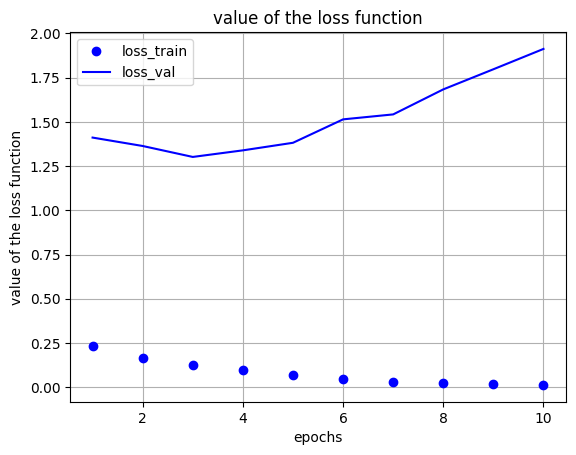

In [30]:

loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

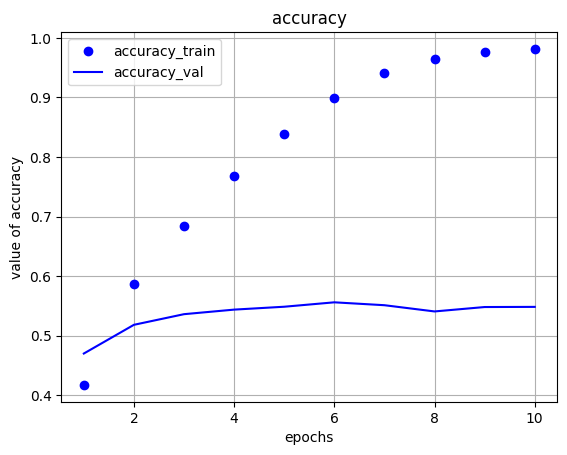

In [31]:

acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

In [32]:
cm = confusion_matrix(test_labels, pred_test_labels)

In [37]:
cm

array([[210,   3,  62,  31,  89,  19,  53],
       [105, 182,  35,  14,  42,   0,  14],
       [ 55,   2, 191,  28, 107,  54,  59],
       [ 43,   2,  46, 610,  75,  37,  82],
       [ 69,   4,  88,  39, 315,  31, 107],
       [ 17,   0,  47,  20,  11, 308,  12],
       [ 57,   1,  66,  54, 118,  25, 286]])

In [33]:
alexnet = models.Sequential()

# Layer 1
alexnet.add(Conv2D(96, (11, 11), input_shape=(48, 48, 1), padding='same', activation='tanh'))
alexnet.add(BatchNormalization())
alexnet.add(MaxPool2D(pool_size=(2, 2)))

# Layer 2
alexnet.add(Conv2D(256, (5, 5), padding='same', activation='tanh'))
alexnet.add(BatchNormalization())
alexnet.add(MaxPool2D(pool_size=(2, 2)))

# Layer 3
alexnet.add(ZeroPadding2D((1, 1)))
alexnet.add(Conv2D(512, (3, 3), padding='same', activation='tanh'))
alexnet.add(BatchNormalization())
alexnet.add(MaxPool2D(pool_size=(2, 2)))

# Layer 4
alexnet.add(ZeroPadding2D((1, 1)))
alexnet.add(Conv2D(1024, (3, 3), padding='same', activation='tanh'))
alexnet.add(BatchNormalization())

# Layer 5
alexnet.add(ZeroPadding2D((1, 1)))
alexnet.add(Conv2D(1024, (3, 3), padding='same', activation='tanh'))
alexnet.add(BatchNormalization())
alexnet.add(MaxPool2D(pool_size=(2, 2)))

# Layer 6
alexnet.add(Flatten())
alexnet.add(Dense(4096, activation='tanh'))
alexnet.add(BatchNormalization())
alexnet.add(Dropout(0.5))

# Layer 7
alexnet.add(Dense(4096, activation='tanh'))
alexnet.add(BatchNormalization())
alexnet.add(Dropout(0.5))

# Layer 8
alexnet.add(Dense(7, activation='softmax'))
alexnet.add(BatchNormalization())

# print model summary
alexnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 96)        11712     
                                                                 
 batch_normalization_3 (Batc  (None, 48, 48, 96)       384       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 24, 96)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 256)       614656    
                                                                 
 batch_normalization_4 (Batc  (None, 24, 24, 256)      1024      
 hNormalization)                                                 
                                                      

In [34]:
alexnet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
history = alexnet.fit(train_images, train_labels,
                    validation_data = (val_images, val_labels),
                    class_weight = class_weight,
                    epochs=25,
                    batch_size=50)

Epoch 1/25
627/627 [==============================] - 95s 135ms/step - loss: 1.1558 - accuracy: 0.1627 - val_loss: 10.1853 - val_accuracy: 0.1245
Epoch 2/25
627/627 [==============================] - 83s 132ms/step - loss: 1.1206 - accuracy: 0.1798 - val_loss: 7.3464 - val_accuracy: 0.1653
Epoch 3/25
627/627 [==============================] - 83s 132ms/step - loss: 1.0843 - accuracy: 0.1511 - val_loss: 5.6462 - val_accuracy: 0.1485
Epoch 4/25
627/627 [==============================] - 83s 132ms/step - loss: 0.8785 - accuracy: 0.1207 - val_loss: 8.2915 - val_accuracy: 0.1306
Epoch 5/25
627/627 [==============================] - 83s 132ms/step - loss: 1.0347 - accuracy: 0.1516 - val_loss: 5.8404 - val_accuracy: 0.1595
Epoch 6/25
627/627 [==============================] - 83s 132ms/step - loss: 1.1863 - accuracy: 0.1708 - val_loss: 7.4764 - val_accuracy: 0.1429
Epoch 7/25
627/627 [==============================] - 82s 131ms/step - loss: 1.4858 - accuracy: 0.1715 - val_loss: 11.7959 - val_

In [48]:
model.save('/content/drive/MyDrive/Mood-Detection-Project/challenges-in-representation-learning-facial-expression-recognition-challenge/model.h5')


In [52]:
import cv2
import numpy as np
import tensorflow as tf

# Load pre-trained Haar Cascade classifier for face detection
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# Load pre-trained machine learning model for mood prediction
model = tf.keras.models.load_model('/content/drive/MyDrive/Mood-Detection-Project/challenges-in-representation-learning-facial-expression-recognition-challenge/model.h5')

# Define a dictionary to map predicted class indices to mood labels
mood_labels = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}

# Open video capture device
cap = cv2.VideoCapture(0)

cap.isOpened()

# Loop over frames from video capture device
while True:
    # Read frame from video capture device
    ret, frame = cap.read()

    # Convert frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in frame using Haar Cascade classifier
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    # Loop over detected faces
    for (x, y, w, h) in faces:
        # Extract face ROI (Region of Interest)
        face_roi = gray[y:y+h, x:x+w]
        # Resize face ROI to fit model input size
        face_roi = cv2.resize(face_roi, (48, 48))
        # Normalize pixel values to range [0, 1]
        face_roi = face_roi / 255.0
        # Reshape face ROI to match model input shape
        face_roi = np.reshape(face_roi, (1, 48, 48, 1))
        # Make mood prediction using pre-trained model
        prediction = model.predict(face_roi)
        # Get predicted mood label
        mood_label = mood_labels[np.argmax(prediction)]
        # Draw bounding box around detected face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        # Write predicted mood label on top of bounding box
        cv2.putText(frame, mood_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display output frame
    cv2.imshow('Output', frame)

    # Exit loop if 'q' key is pressed
    if cv2.waitKey(1) == ord('q'):
        break

# Release video capture device and close all windows
cap.release()
cv2.destroyAllWindows()

False